# U-Net++ Change Detection Training Notebook
This notebook trains a U-Net++ model for change detection using A/B/label folders for train, val, and test. It includes installation, data loading, training with early stopping, saving metrics, and displaying results.

## Assignment Compliance (Segmentation)
- Problem: Change detection (binary segmentation of change mask)
- Model: U-Net++ (recent variant, deeper variant over base U-Net)
- Epochs: Min 50 with early stopping (patience 10)
- Data: Using existing train / val / test folders exactly as provided (no re-splitting enforced).
- Metrics tracked: IoU, Dice, Precision, Recall, F1, Accuracy, Loss + confusion matrix (pixel-wise)
- Outputs: Metric plots, sample predictions, parameter count, GFLOPs, saved best weights.
- Saved artifacts: best_model.pth, training_history.csv, test_metrics.csv, confusion_matrix.txt, prediction PNGs.


In [1]:
# Install all required packages
!pip install segmentation-models-pytorch torch torchvision albumentations scikit-learn pandas tqdm thop torchinfo matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00:00:0100:01


In [2]:
# Imports & Setup for custom U-Net++ training (from scratch style like Siamese notebook)
import os, random, math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device & Reproducibility
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Using device: {DEVICE}")

# Loss components (Dice + BCE)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        # preds: probabilities after sigmoid, targets: binary
        preds = preds.contiguous()
        targets = targets.contiguous()
        intersection = (preds * targets).sum(dim=(2,3))
        denom = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2 * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

def combined_loss(logits, targets, bce_w=0.6, dice_w=0.4):
    bce = nn.BCEWithLogitsLoss()(logits, targets)
    probs = torch.sigmoid(logits)
    dloss = DiceLoss()(probs, targets)
    return bce_w * bce + dice_w * dloss

@torch.no_grad()
def batch_metrics(logits, targets, thresh=0.3):  # Changed to 0.3 threshold
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    p = preds.view(-1).cpu().numpy()
    t = targets.view(-1).cpu().numpy()
    # Confusion components
    cm = confusion_matrix(t, p, labels=[0,1]) if (t.sum()>0 or p.sum()>0) else np.array([[len(t),0],[0,0]])
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
    else:  # degenerate
        tn = fp = fn = tp = 0
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2*tp) / (2*tp + fp + fn + eps)
    precision = tp / (tp + fp + eps) if (tp+fp)>0 else 0.0
    recall = tp / (tp + fn + eps) if (tp+fn)>0 else 0.0
    f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return dict(tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn), iou=float(iou), dice=float(dice), precision=float(precision), recall=float(recall), f1=float(f1), acc=float(acc))

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best=True, min_epochs=10):  # Changed patience to 10
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = None
        self.counter = 0
        self.best_state = None
        self.min_epochs = min_epochs
    def __call__(self, epoch, current_loss, model):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            if self.restore_best:
                self.best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.counter += 1
        if epoch+1 < self.min_epochs:
            return False
        if self.counter >= self.patience:
            if self.restore_best and self.best_state is not None:
                model.load_state_dict(self.best_state)
            return True
        return False

Using device: cuda


In [3]:
# Dataset (from scratch style, similar to Siamese approach)
DATA_ROOT = '/kaggle/input/earthquakedatasetnew/earthquakeDataset'  # Adjust to local path as needed
IMG_SIZE = (256, 256)
TRAIN_BATCH = 6
VAL_BATCH = 2
TEST_BATCH = 1

transform_img = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

class ChangeDataset(Dataset):
    def __init__(self, root, split='train'):
        if split=='train':
            a_dir = os.path.join(root,'train','A_train_aug')
            b_dir = os.path.join(root,'train','B_train_aug')
            m_dir = os.path.join(root,'train','label_train_aug')
        elif split=='val':
            a_dir = os.path.join(root,'val','A_val')
            b_dir = os.path.join(root,'val','B_val')
            m_dir = os.path.join(root,'val','label_val')
        else:
            a_dir = os.path.join(root,'test','A_test')
            b_dir = os.path.join(root,'test','B_test')
            m_dir = os.path.join(root,'test','label_test')
        self.a_files = sorted([f for f in os.listdir(a_dir) if f.endswith('.png')])
        self.a_dir, self.b_dir, self.m_dir = a_dir, b_dir, m_dir
    def __len__(self): return len(self.a_files)
    def __getitem__(self, idx):
        name = self.a_files[idx]
        a = Image.open(os.path.join(self.a_dir,name)).convert('RGB')
        b = Image.open(os.path.join(self.b_dir,name)).convert('RGB')
        m = Image.open(os.path.join(self.m_dir,name)).convert('L')
        a = transform_img(a)
        b = transform_img(b)
        m = transform_mask(m)
        m = (m>0.5).float()
        x = torch.cat([a,b], dim=0)  # 6 channels
        return x, m

train_ds = ChangeDataset(DATA_ROOT,'train')
val_ds = ChangeDataset(DATA_ROOT,'val')
test_ds = ChangeDataset(DATA_ROOT,'test')

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=TEST_BATCH, shuffle=False, num_workers=1)

print(f"Train {len(train_ds)} | Val {len(val_ds)} | Test {len(test_ds)}")

Train 2268 | Val 189 | Test 189


In [4]:
# Custom U-Net++ (Nested U-Net) implementation with Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x

class UNetPP(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, filters=(32,64,128,256,512), deep_supervision=False, dropout_rates=None):
        super().__init__()
        self.deep_supervision = deep_supervision
        f = filters
        
        # Define dropout rates for different layers
        if dropout_rates is None:
            dropout_rates = {
                'encoder': [0.0, 0.0, 0.0, 0.1, 0.15],  # Increasing dropout in deeper layers
                'decoder': [0.3, 0.25, 0.2, 0.15],       # Decreasing dropout in decoder
                'skip': 0.2,                              # Dropout for skip connections
                'final': 0.2                              # Dropout before final output
            }
        
        # Encoder base layers (x_0_0 .. x_4_0) with increasing dropout
        self.x_0_0 = ConvBlock(in_ch, f[0], dropout_rates['encoder'][0])
        self.x_1_0 = ConvBlock(f[0], f[1], dropout_rates['encoder'][1])
        self.x_2_0 = ConvBlock(f[1], f[2], dropout_rates['encoder'][2])
        self.x_3_0 = ConvBlock(f[2], f[3], dropout_rates['encoder'][3])
        self.x_4_0 = ConvBlock(f[3], f[4], dropout_rates['encoder'][4])  # Bottleneck - highest dropout
        
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Nested decoder blocks (dense skip connections) with decreasing dropout
        self.x_0_1 = ConvBlock(f[0]+f[1], f[0], dropout_rates['skip'])
        self.x_1_1 = ConvBlock(f[1]+f[2], f[1], dropout_rates['skip'])
        self.x_2_1 = ConvBlock(f[2]+f[3], f[2], dropout_rates['skip'])
        self.x_3_1 = ConvBlock(f[3]+f[4], f[3], dropout_rates['decoder'][0])

        self.x_0_2 = ConvBlock(f[0]*2+f[1], f[0], dropout_rates['skip'])
        self.x_1_2 = ConvBlock(f[1]*2+f[2], f[1], dropout_rates['skip'])
        self.x_2_2 = ConvBlock(f[2]*2+f[3], f[2], dropout_rates['decoder'][1])

        self.x_0_3 = ConvBlock(f[0]*3+f[1], f[0], dropout_rates['skip'])
        self.x_1_3 = ConvBlock(f[1]*3+f[2], f[1], dropout_rates['decoder'][2])

        self.x_0_4 = ConvBlock(f[0]*4+f[1], f[0], dropout_rates['decoder'][3])

        # Final layers with dropout
        self.final_dropout = nn.Dropout2d(dropout_rates['final'])
        self.final = nn.Conv2d(f[0], out_ch, 1)
    
    def forward(self, x):
        # Encoder path
        x_0_0 = self.x_0_0(x)
        x_1_0 = self.x_1_0(self.pool(x_0_0))
        x_0_1 = self.x_0_1(torch.cat([x_0_0, self.up(x_1_0)], dim=1))

        x_2_0 = self.x_2_0(self.pool(x_1_0))
        x_1_1 = self.x_1_1(torch.cat([x_1_0, self.up(x_2_0)], dim=1))
        x_0_2 = self.x_0_2(torch.cat([x_0_0, x_0_1, self.up(x_1_1)], dim=1))

        x_3_0 = self.x_3_0(self.pool(x_2_0))
        x_2_1 = self.x_2_1(torch.cat([x_2_0, self.up(x_3_0)], dim=1))
        x_1_2 = self.x_1_2(torch.cat([x_1_0, x_1_1, self.up(x_2_1)], dim=1))
        x_0_3 = self.x_0_3(torch.cat([x_0_0, x_0_1, x_0_2, self.up(x_1_2)], dim=1))

        # Bottleneck
        x_4_0 = self.x_4_0(self.pool(x_3_0))
        
        # Decoder path
        x_3_1 = self.x_3_1(torch.cat([x_3_0, self.up(x_4_0)], dim=1))
        x_2_2 = self.x_2_2(torch.cat([x_2_0, x_2_1, self.up(x_3_1)], dim=1))
        x_1_3 = self.x_1_3(torch.cat([x_1_0, x_1_1, x_1_2, self.up(x_2_2)], dim=1))
        x_0_4 = self.x_0_4(torch.cat([x_0_0, x_0_1, x_0_2, x_0_3, self.up(x_1_3)], dim=1))

        # Final prediction with dropout
        out = self.final_dropout(x_0_4)
        out = self.final(out)
        return out

# Dropout configurations
very_aggressive_dropout = {
    'encoder': [0.0, 0.15, 0.25, 0.4, 0.6],  # Very high dropout
    'decoder': [0.6, 0.5, 0.4, 0.3],         # Very high dropout
    'skip': 0.4,                              # High dropout for skip connections
    'final': 0.4                              # High dropout before final output
}

# Start with very aggressive configuration
model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512), 
               dropout_rates=very_aggressive_dropout).to(DEVICE)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

# Modified optimizer settings for better convergence with dropout
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)
early_stop = EarlyStopping(patience=10, min_delta=1e-4, min_epochs=10)  # Changed patience to 10

EPOCHS = 200
history = []

for epoch in range(EPOCHS):
    model.train()  # Important: enables dropout
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Train", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = combined_loss(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()  # Important: disables dropout
    val_loss = 0.0
    agg = dict(tp=0,fp=0,fn=0,tn=0)
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Val", leave=False):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = combined_loss(logits, yb)
            val_loss += loss.item() * xb.size(0)
            mets = batch_metrics(logits, yb, thresh=0.3)  # Using 0.3 threshold
            for k in agg: agg[k] += mets[k]
    
    val_loss /= len(val_loader.dataset)
    eps=1e-8
    tp,fp,fn,tn = agg['tp'],agg['fp'],agg['fn'],agg['tn']
    iou = tp / (tp+fp+fn+eps)
    dice = (2*tp)/(2*tp+fp+fn+eps)
    precision = tp/(tp+fp+eps) if (tp+fp)>0 else 0
    recall = tp/(tp+fn+eps) if (tp+fn)>0 else 0
    f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0
    acc = (tp+tn)/(tp+tn+fp+fn+eps)
    history.append(dict(epoch=epoch+1, train_loss=train_loss, val_loss=val_loss, IoU=iou, Dice=dice, Precision=precision, Recall=recall, F1=f1, Accuracy=acc))

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: TL {train_loss:.4f} VL {val_loss:.4f} IoU {iou:.4f} Dice {dice:.4f} F1 {f1:.4f} LR {optimizer.param_groups[0]['lr']:.2e}")

    # Save best
    if epoch==0 or val_loss == min(h['val_loss'] for h in history):
        torch.save(model.state_dict(), 'best_unetpp.pth')  # Simplified filename

    if early_stop(epoch, val_loss, model):
        print(f"Early stopping at epoch {epoch+1}")
        break

# Save training history
pd.DataFrame(history).to_csv('training_history_unetpp.csv', index=False)  # Simplified filename
print('Training complete.')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model params: 9,160,545


Epoch 1: TL 0.6779 VL 0.5832 IoU 0.1812 Dice 0.3069 F1 0.3069 LR 1.00e-04


Epoch 2: TL 0.5758 VL 0.5081 IoU 0.2605 Dice 0.4134 F1 0.4134 LR 1.00e-04


Epoch 3: TL 0.5313 VL 0.4795 IoU 0.2976 Dice 0.4587 F1 0.4587 LR 1.00e-04


Epoch 4: TL 0.5038 VL 0.4554 IoU 0.3382 Dice 0.5054 F1 0.5054 LR 1.00e-04


Epoch 5: TL 0.4826 VL 0.4412 IoU 0.3329 Dice 0.4995 F1 0.4995 LR 1.00e-04


Epoch 6: TL 0.4726 VL 0.4333 IoU 0.3335 Dice 0.5002 F1 0.5002 LR 1.00e-04


Epoch 7: TL 0.4639 VL 0.4439 IoU 0.3367 Dice 0.5037 F1 0.5037 LR 1.00e-04


Epoch 8: TL 0.4606 VL 0.4207 IoU 0.3654 Dice 0.5352 F1 0.5352 LR 1.00e-04


Epoch 9: TL 0.4519 VL 0.4144 IoU 0.3727 Dice 0.5430 F1 0.5430 LR 1.00e-04


Epoch 10: TL 0.4472 VL 0.4235 IoU 0.3616 Dice 0.5311 F1 0.5311 LR 1.00e-04


Epoch 11: TL 0.4413 VL 0.4125 IoU 0.3739 Dice 0.5443 F1 0.5443 LR 1.00e-04


Epoch 12: TL 0.4364 VL 0.3997 IoU 0.3822 Dice 0.5530 F1 0.5530 LR 1.00e-04


Epoch 13: TL 0.4345 VL 0.4093 IoU 0.3749 Dice 0.5453 F1 0.5453 LR 1.00e-04


Epoch 14: TL 0.4274 VL 0.4010 IoU 0.3815 Dice 0.5523 F1 0.5523 LR 1.00e-04


Epoch 15: TL 0.4252 VL 0.4164 IoU 0.3711 Dice 0.5413 F1 0.5413 LR 1.00e-04


Epoch 16: TL 0.4232 VL 0.4457 IoU 0.3197 Dice 0.4845 F1 0.4845 LR 1.00e-04


Epoch 17: TL 0.4232 VL 0.4069 IoU 0.3807 Dice 0.5515 F1 0.5515 LR 1.00e-04


Epoch 18: TL 0.4182 VL 0.4112 IoU 0.3776 Dice 0.5482 F1 0.5482 LR 5.00e-05


Epoch 19: TL 0.4101 VL 0.4017 IoU 0.3864 Dice 0.5575 F1 0.5575 LR 5.00e-05


Epoch 20: TL 0.4070 VL 0.4162 IoU 0.3726 Dice 0.5429 F1 0.5429 LR 5.00e-05


Epoch 21: TL 0.4071 VL 0.3943 IoU 0.3978 Dice 0.5691 F1 0.5691 LR 5.00e-05


Epoch 22: TL 0.4043 VL 0.4044 IoU 0.3890 Dice 0.5601 F1 0.5601 LR 5.00e-05


Epoch 23: TL 0.4013 VL 0.3841 IoU 0.4049 Dice 0.5764 F1 0.5764 LR 5.00e-05


Epoch 24: TL 0.4019 VL 0.3909 IoU 0.3960 Dice 0.5673 F1 0.5673 LR 5.00e-05


Epoch 25: TL 0.3988 VL 0.3958 IoU 0.3956 Dice 0.5669 F1 0.5669 LR 5.00e-05


Epoch 26: TL 0.4000 VL 0.3994 IoU 0.3964 Dice 0.5678 F1 0.5678 LR 5.00e-05


Epoch 27: TL 0.3967 VL 0.3969 IoU 0.3930 Dice 0.5642 F1 0.5642 LR 5.00e-05


Epoch 28: TL 0.3959 VL 0.4072 IoU 0.3859 Dice 0.5569 F1 0.5569 LR 5.00e-05


Epoch 29: TL 0.3977 VL 0.3902 IoU 0.4028 Dice 0.5743 F1 0.5743 LR 2.50e-05


Epoch 30: TL 0.3876 VL 0.3974 IoU 0.3985 Dice 0.5699 F1 0.5699 LR 2.50e-05


Epoch 31: TL 0.3897 VL 0.3918 IoU 0.3979 Dice 0.5693 F1 0.5693 LR 2.50e-05


Epoch 32: TL 0.3877 VL 0.4220 IoU 0.3617 Dice 0.5312 F1 0.5312 LR 2.50e-05


Epoch 33: TL 0.3908 VL 0.4006 IoU 0.3932 Dice 0.5644 F1 0.5644 LR 2.50e-05
Early stopping at epoch 33
Training complete.


In [5]:
# Test evaluation
model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512), 
               dropout_rates=very_aggressive_dropout).to(DEVICE)

# Load the trained weights
model.load_state_dict(torch.load('best_unetpp.pth', map_location=DEVICE))
model.eval()  # IMPORTANT: This disables dropout for inference

agg = dict(tp=0,fp=0,fn=0,tn=0)
all_preds = []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Test", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        mets = batch_metrics(logits, yb, thresh=0.3)  # Using 0.3 threshold
        for k in agg: agg[k] += mets[k]
        probs = torch.sigmoid(logits)
        preds = (probs>=0.3).float().cpu()  # Using 0.3 threshold
        all_preds.append(preds)

all_preds = torch.cat(all_preds, dim=0)
eps=1e-8
tp,fp,fn,tn = agg['tp'],agg['fp'],agg['fn'],agg['tn']
iou = tp/(tp+fp+fn+eps)
dice = (2*tp)/(2*tp+fp+fn+eps)
precision = tp/(tp+fp+eps) if (tp+fp)>0 else 0
recall = tp/(tp+fn+eps) if (tp+fn)>0 else 0
f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0
acc = (tp+tn)/(tp+tn+fp+fn+eps)

cm = np.array([[tn, fp],[fn, tp]])
metrics = dict(IoU=iou, Dice=dice, Precision=precision, Recall=recall, F1=f1, Accuracy=acc, TP=tp, FP=fp, FN=fn, TN=tn)

print('\nTest Metrics (With Dropout):')
print(f'IoU: {iou:.4f}')
print(f'Dice: {dice:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

# Save results
pd.DataFrame([metrics]).to_csv('test_metrics_unetpp.csv', index=False)
np.savetxt('confusion_matrix_unetpp.txt', cm, fmt='%d')

# Save first 10 prediction masks
os.makedirs('test_predictions_unetpp', exist_ok=True)
for i in range(min(10, all_preds.shape[0])):
    img = (all_preds[i,0].numpy()*255).astype('uint8')
    Image.fromarray(img).save(f'test_predictions_unetpp/pred_{i}.png')
print('Saved prediction samples.')
print("Testing complete with 0.3 threshold!")


Test Metrics (With Dropout):
IoU: 0.4542
Dice: 0.6247
Precision: 0.6016
Recall: 0.6496
F1: 0.6247
Saved prediction samples.
Testing complete with 0.3 threshold!


History head:
   epoch  train_loss  val_loss       IoU      Dice  Precision    Recall  \
0      1    0.677949  0.583185  0.181241  0.306866   0.190584  0.787111   
1      2    0.575816  0.508108  0.260548  0.413388   0.309948  0.620456   
2      3    0.531296  0.479477  0.297578  0.458667   0.343061  0.691787   
3      4    0.503808  0.455377  0.338152  0.505401   0.454711  0.568810   
4      5    0.482620  0.441176  0.332853  0.499459   0.411779  0.634580   

         F1  Accuracy  
0  0.306866  0.603917  
1  0.413388  0.803851  
2  0.458667  0.818105  
3  0.505401  0.875987  
4  0.499459  0.858320  


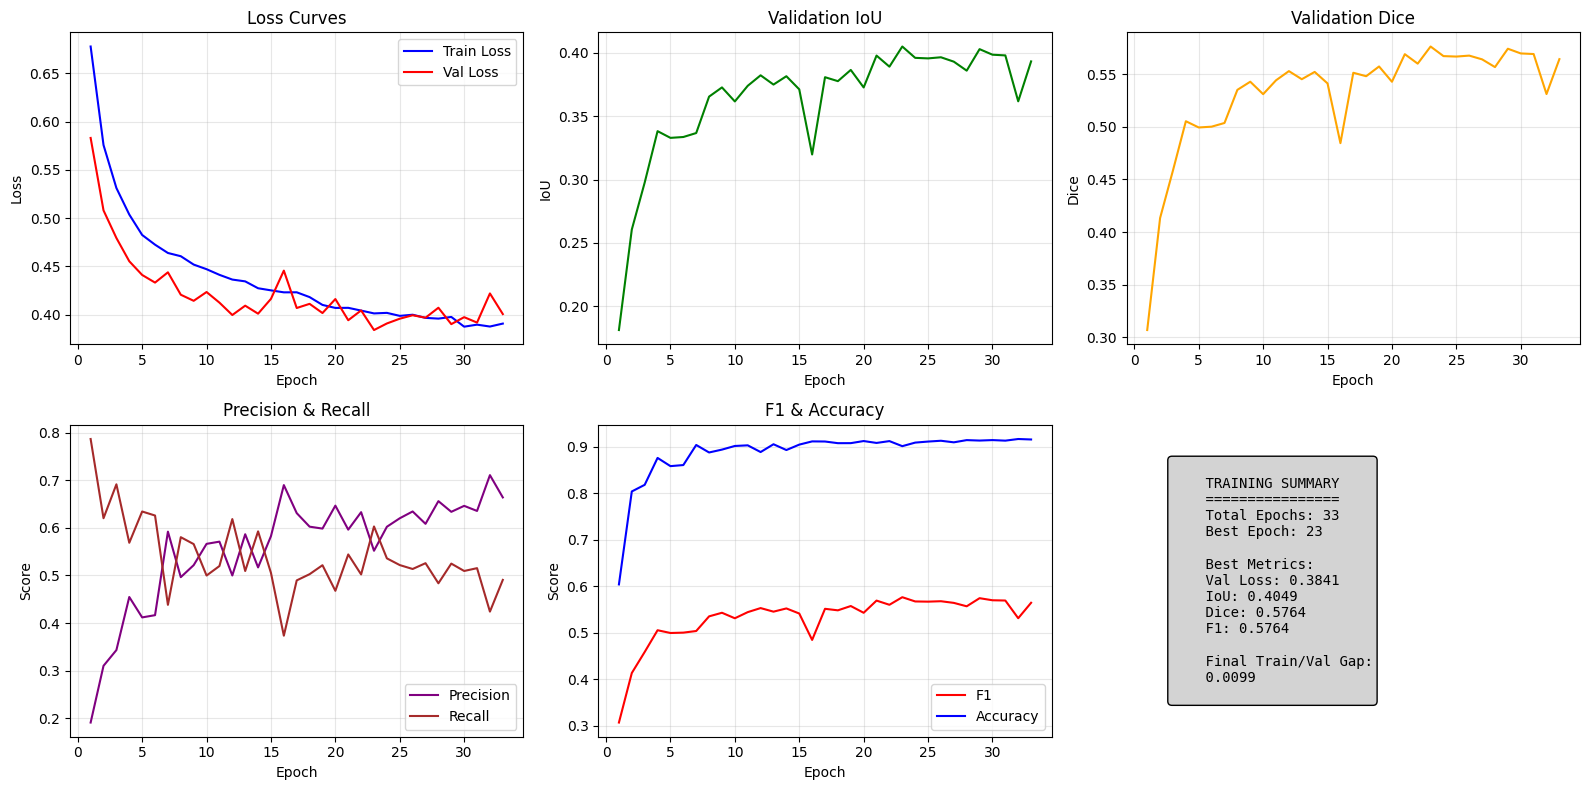

Visualization complete!


In [6]:
# Visualization
hist_df = pd.read_csv('training_history_unetpp.csv')
print('History head:')
print(hist_df.head())

# Create training plots
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,8))

# Plot 1: Loss curves
ax1.plot(hist_df['epoch'], hist_df['train_loss'], label='Train Loss', color='blue')
ax1.plot(hist_df['epoch'], hist_df['val_loss'], label='Val Loss', color='red')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: IoU
ax2.plot(hist_df['epoch'], hist_df['IoU'], label='IoU', color='green')
ax2.set_title('Validation IoU')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IoU')
ax2.grid(True, alpha=0.3)

# Plot 3: Dice
ax3.plot(hist_df['epoch'], hist_df['Dice'], label='Dice', color='orange')
ax3.set_title('Validation Dice')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Dice')
ax3.grid(True, alpha=0.3)

# Plot 4: Precision & Recall
ax4.plot(hist_df['epoch'], hist_df['Precision'], label='Precision', color='purple')
ax4.plot(hist_df['epoch'], hist_df['Recall'], label='Recall', color='brown')
ax4.set_title('Precision & Recall')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Score')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: F1 & Accuracy
ax5.plot(hist_df['epoch'], hist_df['F1'], label='F1', color='red')
ax5.plot(hist_df['epoch'], hist_df['Accuracy'], label='Accuracy', color='blue')
ax5.set_title('F1 & Accuracy')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Score')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Summary statistics
ax6.axis('off')
if len(hist_df) > 0:
    best_epoch = hist_df.loc[hist_df['val_loss'].idxmin(), 'epoch']
    best_val_loss = hist_df['val_loss'].min()
    best_iou = hist_df['IoU'].max()
    best_dice = hist_df['Dice'].max()
    best_f1 = hist_df['F1'].max()
    
    summary_text = f"""
    TRAINING SUMMARY
    ================
    Total Epochs: {len(hist_df)}
    Best Epoch: {best_epoch}
    
    Best Metrics:
    Val Loss: {best_val_loss:.4f}
    IoU: {best_iou:.4f}
    Dice: {best_dice:.4f}
    F1: {best_f1:.4f}
    
    Final Train/Val Gap:
    {hist_df['val_loss'].iloc[-1] - hist_df['train_loss'].iloc[-1]:.4f}
    """
    ax6.text(0.1, 0.5, summary_text, fontsize=10, fontfamily='monospace',
             verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Visualization complete!")